In [2]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import scanpy as sc
import pandas as pd
import torch
import scipy
import time
from STEM.model import *
from STEM.utils import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [47]:
scdata

,Abcc4,Acp5,Acvr1,Acvr2a,Adora2b,Afp,Ahnak,Akr1c19,Alas2,Aldh1a2,...,Wnt2b,Wnt3,Wnt3a,Wnt5a,Wnt5b,Wnt8a,Xist,Zfp444,Zfp57,Zic3
embryo1_Pos0_cell100_z2,0.000000,1.498872,0.000000,0.000000,0.000000,1.498872,0.000000,0.000000,1.498872,0.000000,...,0.0,0.0,1.007344,0.000000,0.000000,1.007344,1.007344,0.000000,0.000000,1.007344
embryo1_Pos0_cell101_z2,0.000000,1.013315,0.000000,1.013315,0.000000,0.000000,1.013315,0.000000,1.013315,1.013315,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
embryo1_Pos0_cell102_z2,0.000000,0.000000,0.190564,0.000000,0.190564,0.000000,0.815185,0.815185,0.190564,0.350561,...,0.0,0.0,0.000000,1.196723,0.190564,0.190564,1.607178,0.488455,0.190564,0.000000
embryo1_Pos0_cell105_z2,0.000000,1.559738,0.000000,1.057369,0.000000,0.000000,0.000000,0.000000,1.559738,0.000000,...,0.0,0.0,0.000000,1.057369,1.057369,0.000000,0.000000,0.000000,1.057369,0.000000
embryo1_Pos0_cell106_z2,0.000000,0.528643,0.528643,0.000000,0.000000,0.000000,0.528643,1.128135,0.872656,0.000000,...,0.0,0.0,0.872656,1.500325,0.000000,0.000000,0.872656,1.128135,0.528643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
embryo1_Pos28_cell94_z2,0.913878,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.557893,0.000000,0.913878,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.554969,0.557893,0.000000
embryo1_Pos28_cell95_z2,0.000000,0.000000,0.394146,0.676120,0.000000,0.000000,0.394146,0.676120,0.000000,1.985202,...,0.0,0.0,0.000000,0.000000,0.676120,0.000000,1.477464,0.676120,0.676120,0.394146
embryo1_Pos28_cell96_z2,0.000000,0.533298,0.000000,0.000000,0.000000,0.000000,0.000000,0.879250,0.000000,1.135791,...,0.0,0.0,0.000000,0.000000,0.533298,0.000000,1.653890,0.533298,0.533298,0.533298
embryo1_Pos28_cell97_z2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.421302,0.944618,0.421302,0.000000,...,0.0,0.0,0.421302,0.421302,0.421302,0.000000,0.716809,0.944618,0.000000,0.000000


In [3]:
scdata = pd.read_csv('./data/mousedata_2020/E1z2/simu_sc_counts.csv',index_col=0)
scdata = scdata.T
stdata = pd.read_csv('data/mousedata_2020/E1z2/simu_st_counts.csv',index_col=0)
stdata = stdata.T
stgtcelltype = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_celltype.csv',index_col=0)
spcoor = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_metadata.csv',index_col=0)
scmetadata = pd.read_csv('./data/mousedata_2020/E1z2/metadata.csv',index_col=0)

adata = sc.AnnData(scdata,obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

adata.obsm['spatial'] = scmetadata[['x_global','y_global']].values
stadata.obsm['spatial'] = spcoor

In [4]:
sc.pp.calculate_qc_metrics(adata,percent_top=None, log1p=False, inplace=True)
adata.obs['n_genes_by_counts'].median()

sc.pp.calculate_qc_metrics(stadata,percent_top=None, log1p=False, inplace=True)
stadata.obs['n_genes_by_counts'].median()

dp = 1- adata.obs['n_genes_by_counts'].median()/stadata.obs['n_genes_by_counts'].median()
dp

0.5836734693877551

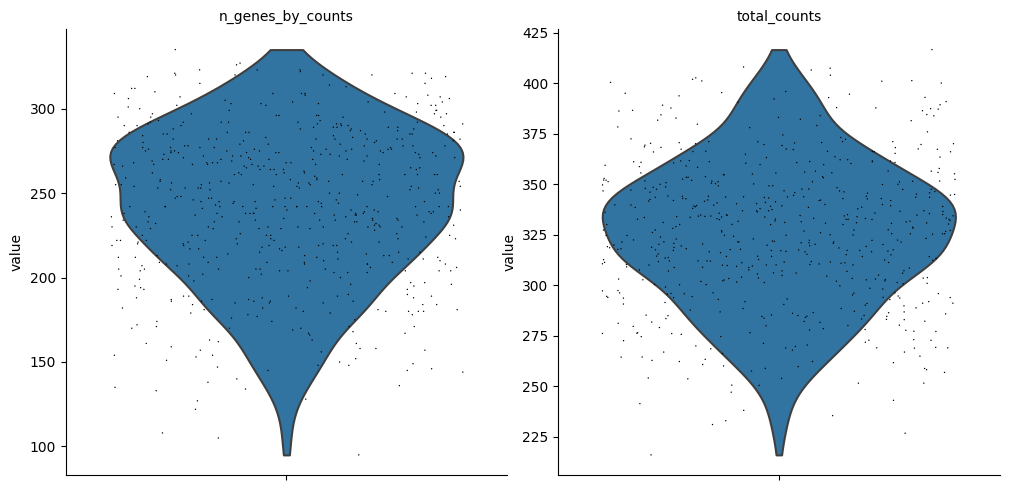

In [5]:
figsize(2,2)
sc.pl.violin(stadata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'embryo' as categorical
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future ver

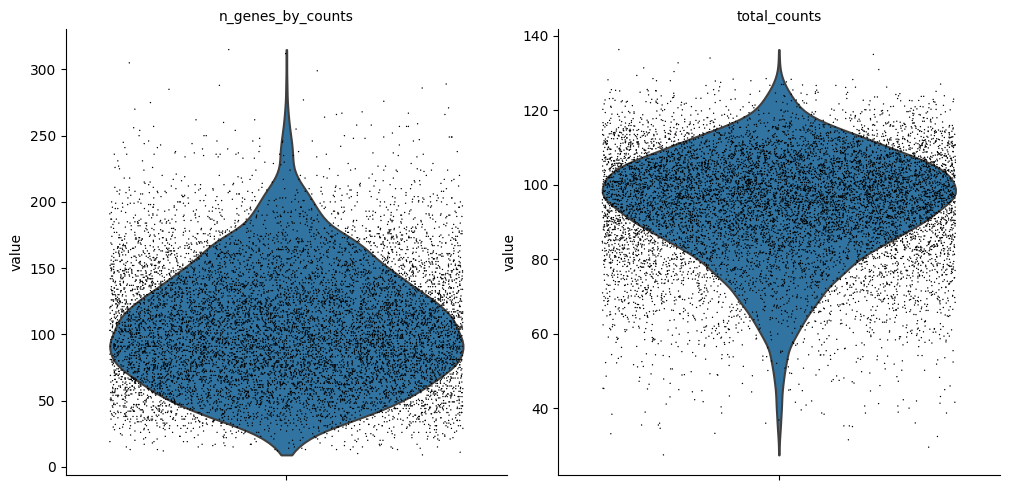

In [6]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

In [7]:
st_neighbor = scipy.spatial.distance.cdist(spcoor,spcoor)
sigma = 3
st_neighbor = np.exp(-st_neighbor**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)

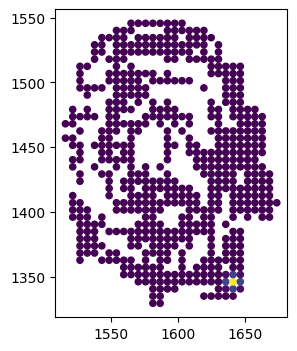

In [8]:
figsize(3,4)
plt.scatter(spcoor.values[:,0],spcoor.values[:,1],c=np.log1p(st_neighbor[30,:]),s=20)

In [9]:
class setting( object ):
    pass
seed_all(2022)
opt= setting()
setattr(opt, 'device', 'cuda:0')
setattr(opt, 'outf', 'log/Mouse_E1z2')
setattr(opt, 'n_genes', 351)
setattr(opt, 'no_bn', False)
setattr(opt, 'lr', 0.002)
setattr(opt, 'sigma', 3)
setattr(opt, 'alpha', 0.8)
setattr(opt, 'verbose', True)
setattr(opt, 'mmdbatch', 1000)
setattr(opt, 'dp', dp)

In [10]:
%%time
testmodel = SOmodel(opt)
testmodel.togpu()
loss_curve = testmodel.train_wholedata(400,torch.tensor(scdata.values).float(),torch.tensor(stdata.values).float(),torch.tensor(spcoor.values).float())

[Train][0] Loss: E 3.624 E_pred 3.582 E_circle 5.264 E_mmd 0.053
[0.002]
[Train][1] Loss: E 4.926 E_pred 4.891 E_circle 5.302 E_mmd 0.044
[0.002]
[Train][2] Loss: E 4.348 E_pred 4.319 E_circle 5.289 E_mmd 0.037
[0.002]
[Train][3] Loss: E 3.473 E_pred 3.448 E_circle 5.031 E_mmd 0.031
[0.002]
[Train][4] Loss: E 3.597 E_pred 3.576 E_circle 4.769 E_mmd 0.027
[0.002]
[Train][5] Loss: E 3.408 E_pred 3.385 E_circle 4.935 E_mmd 0.028
[0.002]
[Train][6] Loss: E 3.373 E_pred 3.349 E_circle 4.666 E_mmd 0.030
[0.002]
[Train][7] Loss: E 3.133 E_pred 3.107 E_circle 4.319 E_mmd 0.032
[0.002]
[Train][8] Loss: E 3.131 E_pred 3.108 E_circle 4.207 E_mmd 0.029
[0.002]
[Train][9] Loss: E 3.062 E_pred 3.041 E_circle 4.165 E_mmd 0.027
[0.002]
[Train][10] Loss: E 3.045 E_pred 3.022 E_circle 4.158 E_mmd 0.029
[0.002]
[Train][11] Loss: E 3.006 E_pred 2.983 E_circle 3.976 E_mmd 0.028
[0.002]
[Train][12] Loss: E 3.009 E_pred 2.981 E_circle 3.909 E_mmd 0.035
[0.002]
[Train][13] Loss: E 2.916 E_pred 2.894 E_circle 

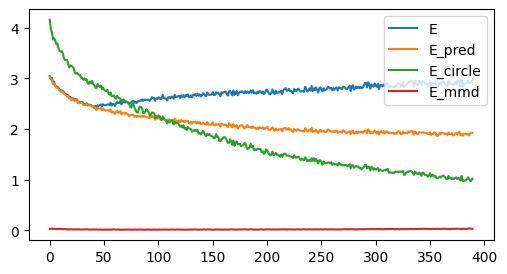

In [11]:
figsize(6,3)
skip=10
N = len(loss_curve['E'])-skip
plt.plot(np.arange(N),loss_curve['E'][skip:],label='E')
plt.plot(np.arange(N),loss_curve['E_pred'][skip:],label='E_pred')
plt.plot(np.arange(N),loss_curve['E_circle'][skip:],label='E_circle')
plt.plot(np.arange(N),loss_curve['E_mmd'][skip:],label='E_mmd')
plt.legend()

In [12]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()

In [13]:
np.save('result/230215_testdp_pure_mmd-E1z2.npy',netst2sc)
np.save('result/230215_testdp_pure_sc2st_mmd-E1z2.npy',netsc2st)
np.save('result/230215_scembbedding-E1z2.npy',scembedding.detach().cpu().numpy())
np.save('result/230215_stembbedding-E1z2.npy',stembedding.detach().cpu().numpy())

In [14]:
testmodel.save()

In [15]:
def all_coord(mappingmtx,spcoor):
    mappingnorm = mappingmtx.div(mappingmtx.sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.coord_x.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.coord_y.values)
    return spaotsc_coord

def k_coord(mappingmtx,spcoor, k=1):
    maskmap = np.zeros_like(mappingmtx)

    argmask = np.argsort(1/mappingmtx.values,axis=1)

    for i in range(argmask.shape[0]):
        for j in range(k):
            maskmap[i,argmask[i,j]]=1

    mappingnorm = (maskmap*mappingmtx).div((maskmap*mappingmtx).sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.coord_x.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.coord_y.values)
    return spaotsc_coord

In [16]:
adata.obsm['spatialDA'] = all_coord(pd.DataFrame(netsc2st,index=adata.obs_names,columns=stadata.obs_names),spcoor)

In [17]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

# Saliency Map

In [18]:
sc.settings.figdir = './result_E1z2/'

## Spinalcoord

In [19]:
spinalcoorddata = scdata[(scmetadata['celltype_mapped_refined']=='Spinal cord')&(scmetadata.y_global>1410)].copy()
spinalcoorddata = torch.Tensor(spinalcoorddata.values).cuda()

spinalmetadata = scmetadata[scmetadata['celltype_mapped_refined']=='Spinal cord']
spinalmetadata = spinalmetadata[spinalmetadata.y_global>1410]

spinaladata = adata[(scmetadata['celltype_mapped_refined']=='Spinal cord')&(scmetadata.y_global>1410),:].copy()

In [20]:
def curve_length(x,y):
    x = np.linspace(0, y-x, 100)
    curve = a5*x**5+a4*x**4 + a3*x**3 + a2*x**2 +a1*x+a0
    return np.sum(np.sqrt(np.sum((curve[:-1] - curve[1:])**2,axis=1)))

In [21]:
spinalspcoor =  spinaladata.obsm['spatial']

a5,a4, a3,a2,a1,a0= np.polyfit(spinalspcoor[:,0],spinalspcoor[:,1],5)
fity = a5*spinalspcoor[:,0]**5+a4*spinalspcoor[:,0]**4 + a3*spinalspcoor[:,0]**3 + a2*spinalspcoor[:,0]**2 +a1*spinalspcoor[:,0]+a0

pseudotime = []
for i in range(spinalspcoor.shape[0]):
    pseudotime.append(curve_length(spinalspcoor[0,:],spinalspcoor[i,:]))

pseudotime = np.array(pseudotime)/1e8
pseudotime = (pseudotime.max() - pseudotime)/(pseudotime.max()-pseudotime.min())
# plt.savefig('nipsfig/embro_spinal_traj.png',bbox_inches='tight',dpi=330)
spinaladata.obs['pseudotime'] = pseudotime
spinaladata.obsm['pseudotime'] = np.expand_dims(np.array(pseudotime),1)

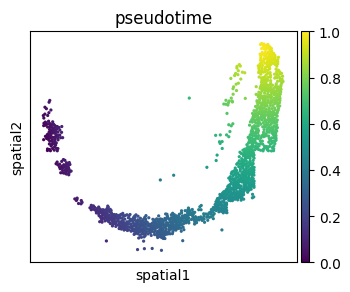

In [22]:
sc.pl.spatial(spinaladata,color='pseudotime',spot_size=2,basis='spatial')

In [23]:
sc.pp.neighbors(spinaladata,use_rep='pseudotime')
sc.tl.leiden(spinaladata,resolution=0.1)

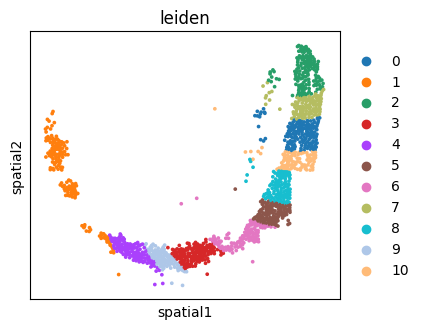

In [24]:
figsize(4,5)
sc.pl.spatial(spinaladata,color='leiden',spot_size=2,save='segments')

In [25]:
class Captummodel(nn.Module):
    def __init__(self, netE, stembedding):
        super(Captummodel, self).__init__()

        self.netE = netE
        self.netE.eval()
        self.stembedding = stembedding.t()

    def forward(self, x):
        x = self.netE(x)
        return x.mm(self.stembedding)
from captum.attr import IntegratedGradients

In [26]:
from tqdm import tqdm
capt = Captummodel(testmodel.netE,stembedding.detach())
capt.eval()


allsali = []
allbestidx = []
alldelta = []
allscemb = []
for i in tqdm(range(spinalcoorddata.shape[0])):
    inputdata = spinalcoorddata[i].unsqueeze(0)
    scembedding = testmodel.netE(inputdata)
    allscemb.append(scembedding.detach().cpu().numpy())
    spinal2st = scembedding.mm(stembedding.detach().t())
    idx = spinal2st.argmax()
    ig = IntegratedGradients(capt)
    attributions,delta = ig.attribute(inputdata,target=idx,return_convergence_delta=True)
    allsali.append(attributions.detach().cpu().numpy()[0])
    alldelta.append(delta.mean().item())
allsali = np.array(allsali)

100%|██████████| 1416/1416 [00:13<00:00, 106.60it/s]


In [27]:
saliadata = sc.AnnData(pd.DataFrame(allsali,columns=scdata.columns,index = spinaladata.obs_names),obs = spinaladata.obs)
saliadata.obsm['spatial'] = spinaladata.obsm['spatial']
saliadata.obsm['spatialDA'] = spinaladata.obsm['spatialDA']

In [28]:
sc.tl.rank_genes_groups(saliadata,groupby='leiden',method='wilcoxon')

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

In [29]:
sc.get.rank_genes_groups_df(saliadata,pval_cutoff =0.05,log2fc_min=0,group=None).names.unique().shape

(272,)

In [50]:
SDGname = sc.get.rank_genes_groups_df(saliadata,pval_cutoff =0.05,log2fc_min=0,group=None).names.unique().tolist()

In [80]:
rgdf = sc.get.rank_genes_groups_df(saliadata,pval_cutoff =0.05,log2fc_min=0,group=None)

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,Hoxa1,10.791059,2.417053,3.793883e-27,1.331653e-24
1,0,Hoxc8,9.198791,2.361854,3.620001e-20,6.353102e-18
2,0,Hoxb1,8.744063,1.385945,2.248735e-18,2.631020e-16
3,0,Ptn,8.492652,2.144000,2.019738e-17,1.772320e-15
4,0,Gata4,8.045975,3.570077,8.556159e-16,6.006424e-14
...,...,...,...,...,...,...
599,10,Dnmt3a,-2.676383,0.574906,7.442145e-03,2.808809e-02
600,10,Hsf1,-2.740397,1.889910,6.136495e-03,2.504546e-02
601,10,Shisa2,-3.259461,1.674938,1.116243e-03,6.219066e-03
602,10,Tcf7l1,-3.912455,0.583557,9.136269e-05,7.635310e-04


In [67]:
salidf = pd.DataFrame(allsali,columns=scdata.columns,index = spinaladata.obs_names)

In [71]:
df1 = scdata.loc[:,SDGname]
df2 = salidf.loc[:,SDGname]

In [78]:
sclop1pspinaldf = scdata[(scmetadata['celltype_mapped_refined']=='Spinal cord')&(scmetadata.y_global>1410)]

In [116]:
import scipy.stats
plist=[]
for name in SDGname:
    tmp1 = sclop1pspinaldf.loc[:,name].values
    tmp2 = salidf.loc[:,name].values
    pear,_ = scipy.stats.pearsonr(tmp1,tmp2)
    p = rgdf.loc[rgdf.names==name,'pvals'].min()
    plist.append([name, pear,p,np.log(p),tmp1.mean()])

In [122]:
corrdf = pd.DataFrame(plist,columns=['name','Pearson','p','p-value','mean'])

<AxesSubplot:xlabel='Pearson', ylabel='p'>

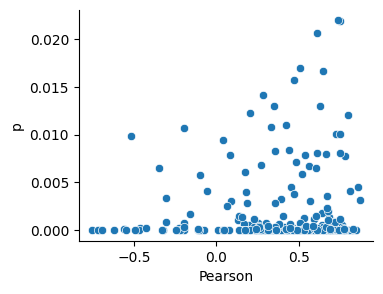

In [123]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = True
rcParams['axes.spines.bottom'] = True
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sns.scatterplot(data=corrdf,x='Pearson',y='p')

<AxesSubplot:xlabel='Pearson', ylabel='p'>

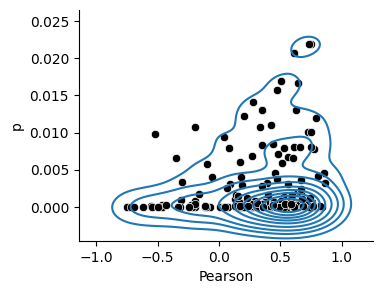

In [133]:
sns.scatterplot(data=corrdf,x='Pearson',y='p',color='black')
sns.kdeplot(data=corrdf,x='Pearson',y='p')

<AxesSubplot:xlabel='Pearson', ylabel='Count'>

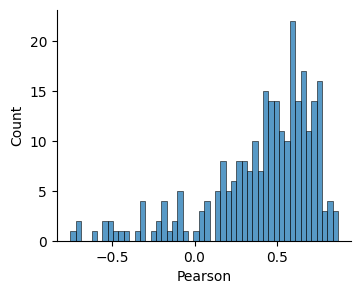

In [126]:
sns.histplot(corrdf.Pearson,bins=50)

In [ ]:
sns.de

<AxesSubplot:xlabel='Pearson', ylabel='mean'>

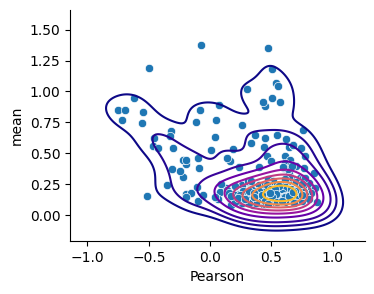

In [148]:
sns.kdeplot(data=corrdf,x='Pearson',y='mean',fill=False, cmap="plasma")
sns.scatterplot(data=corrdf,x='Pearson',y='mean')

In [106]:
corrdf.sort_values('pear')

,name,pear,p-value,mean
111,Sox4,-0.751831,-32.115246,0.848350
211,Xist,-0.715891,-10.684359,0.764532
213,Myh9,-0.694766,-17.457632,0.851739
113,Fzd2,-0.619416,-21.282913,0.948629
69,Tcf7l1,-0.556294,-9.300673,0.747248
...,...,...,...,...
21,Gypa,0.818059,-18.071395,0.200226
141,Afp,0.824460,-9.039499,0.176435
120,Hes3,0.843053,-26.302253,0.338140
50,Perp,0.858134,-5.393183,0.220815


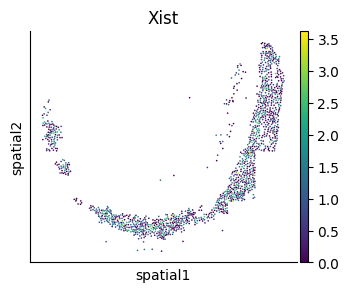

In [115]:
sc.pl.spatial(spinaladata,spot_size=1,color=['Xist'],ncols=6,basis='spatial')

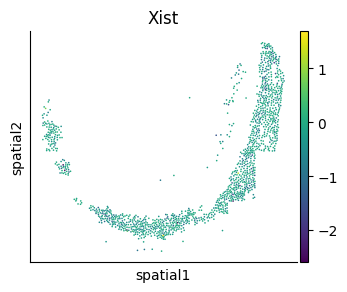

In [114]:
sc.pl.spatial(saliadata,spot_size=1,color=['Xist'],ncols=6,basis='spatial')

In [30]:
maxclt = saliadata.obs['leiden'].values.astype(int).max()
clusteridx =[]
for i in range(maxclt+1):
    clusteridx.append(saliadata.obs.loc[saliadata.obs['leiden']==str(i),'pseudotime'].mean())

a = np.arange(maxclt+1)
reclusterindex = [a for _,a in sorted(zip(clusteridx,a))]

In [31]:
import seaborn as sns
rkgene = pd.DataFrame(saliadata.uns['rank_genes_groups']['names'])
cellorder = saliadata.obs.sort_values('pseudotime').index
salidf = pd.DataFrame(saliadata[cellorder,:].X,index=saliadata[cellorder,:].obs.pseudotime.tolist(),columns=saliadata.var_names)

N=4
topgenelist = []
for i in reclusterindex:
    topgenelist += rkgene.iloc[:N,i].tolist()

sal_plotgenelist=[]
for x in topgenelist:
    if x not in sal_plotgenelist:
        sal_plotgenelist.append(x)
df = salidf.loc[:,sal_plotgenelist].T

In [32]:
plotsali = saliadata[cellorder,:].copy()
sc.pp.scale(plotsali)

In [33]:
import colorbm as cbm

In [34]:
cbm.seq('burg').as_cmap

In [151]:
cbm.pal('npg').as_hex

['#E64B35',
 '#4DBBD5',
 '#00A087',
 '#3C5488',
 '#F39B7F',
 '#8491B4',
 '#91D1C2',
 '#DC0000',
 '#7E6148',
 '#B09C85']

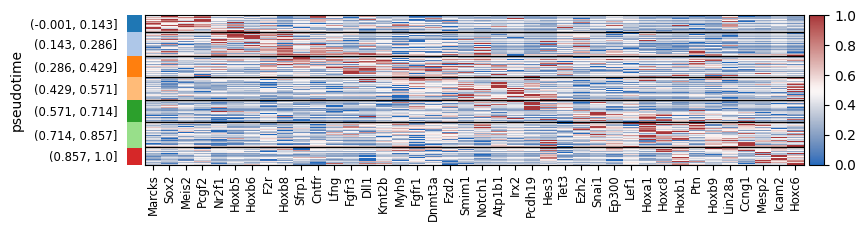

In [42]:
sc.pl.heatmap(plotsali,df.index.tolist(),groupby='pseudotime',cmap=cbm.div('vlag').as_cmap,swap_axes=False,standard_scale='obs',figsize=(9,2),save='spinal_traj_axis.pdf')

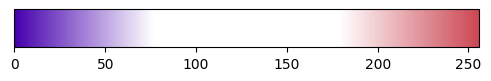

In [48]:
# import matplotlib.colors as mcolors
# def show_cmap(cmap, norm=None, extend=None):
#     '''展示一个colormap.'''
#     if norm is None:
#         norm = mcolors.Normalize(vmin=0, vmax=cmap.N)
#     im = cm.ScalarMappable(norm=norm, cmap=cmap)

#     fig, ax = plt.subplots(figsize=(6, 1))
#     fig.subplots_adjust(bottom=0.5)
#     fig.colorbar(im, cax=ax, orientation='horizontal', extend=extend)
#     plt.show()
    
# colors = ['#436696', 'white',  'white','#CC4855']

# nodes = [0, 0.3,0.7 ,1]
# cmap2 = mcolors.LinearSegmentedColormap.from_list(
#     'cmap2', list(zip(nodes, colors))
# )
# show_cmap(cmap2)

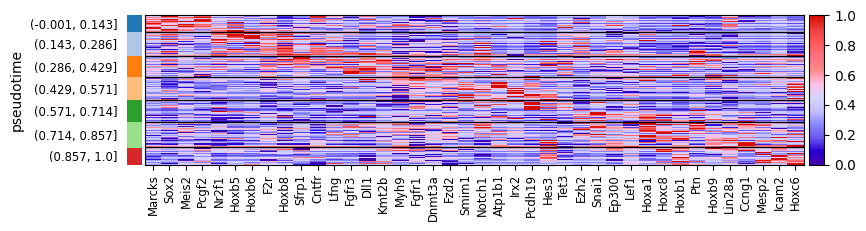

In [55]:
sc.pl.heatmap(plotsali,df.index.tolist(),groupby='pseudotime',cmap=cbm.seq('gsea').as_cmap,swap_axes=False,standard_scale='obs',figsize=(9,2),save='spinal_traj_axis.pdf')

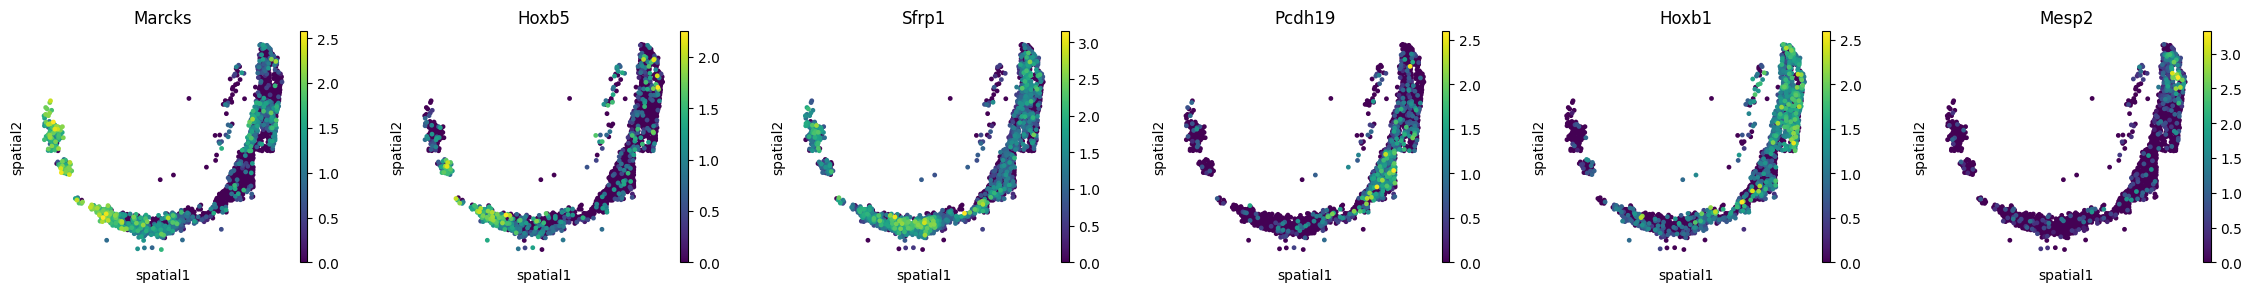

In [33]:
import matplotlib.colors as colors
figsize(3.8,3)
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.bottom'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.spatial(spinaladata,spot_size=3,color=['Marcks','Hoxb5','Sfrp1','Pcdh19','Hoxb1','Mesp2'],ncols=6,basis='spatial',save='trajectory_exrpession.pdf')

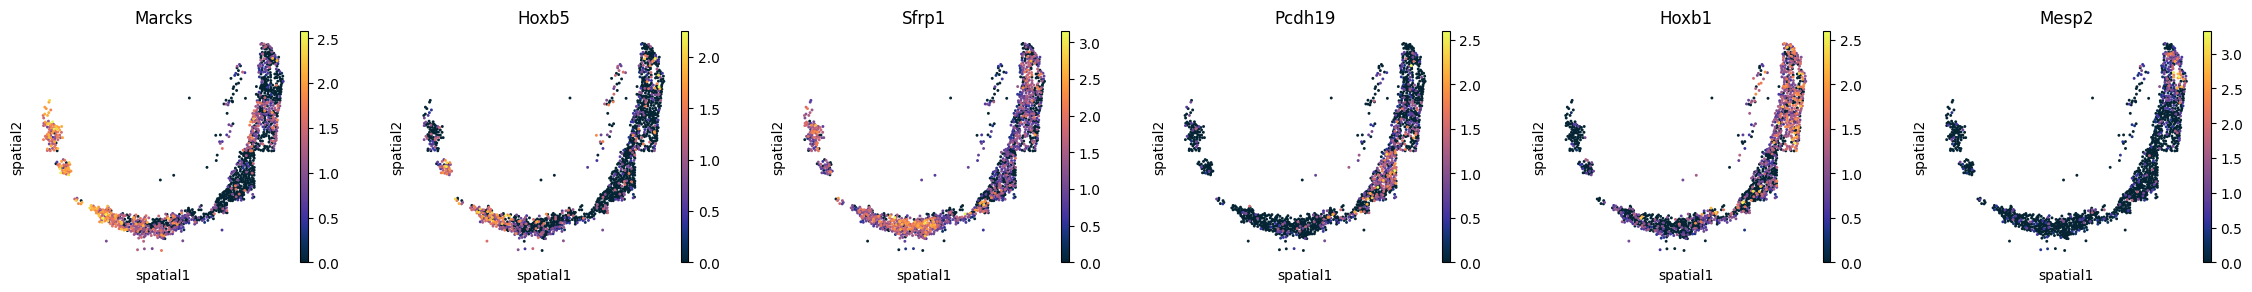

In [43]:

figsize(3.8,3)
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.bottom'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.spatial(spinaladata,spot_size=1.8,color=['Marcks','Hoxb5','Sfrp1','Pcdh19','Hoxb1','Mesp2'],cmap=cbm.seq('thermal').as_cmap,ncols=6,basis='spatial',save='trajectory_exrpession.pdf')

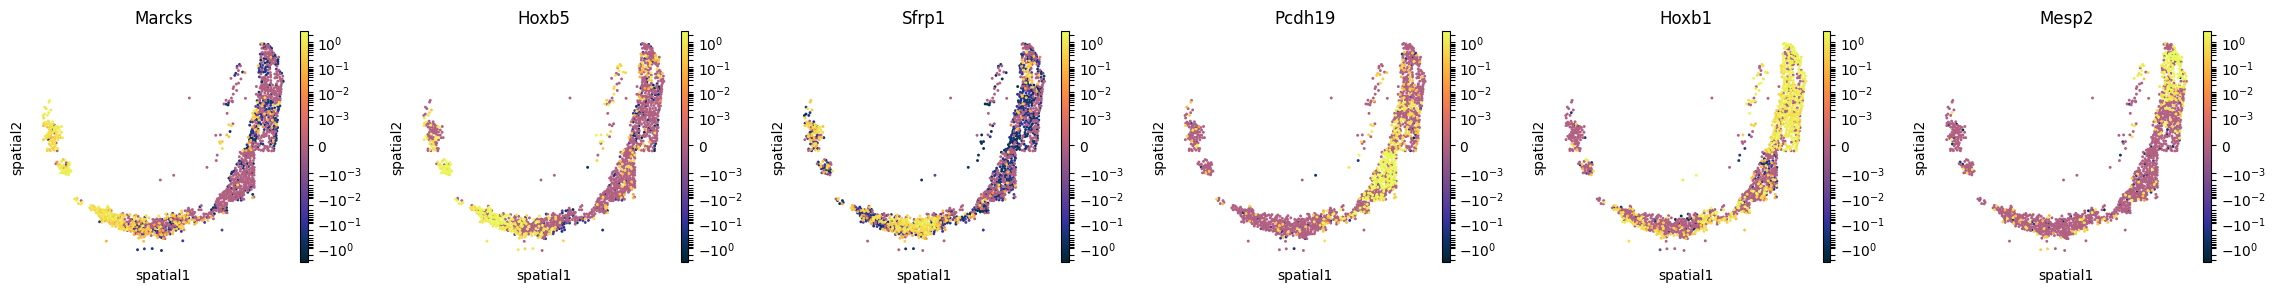

In [46]:
import matplotlib.colors as colors

figsize(3.8,3)
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.bottom'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.spatial(saliadata,spot_size=1.8,color=['Marcks','Hoxb5','Sfrp1','Pcdh19','Hoxb1','Mesp2'],cmap=cbm.seq('thermal').as_cmap,ncols=6,basis='spatial',norm = colors.SymLogNorm(linthresh=0.001,base=10),save='trajectory_attention.pdf')

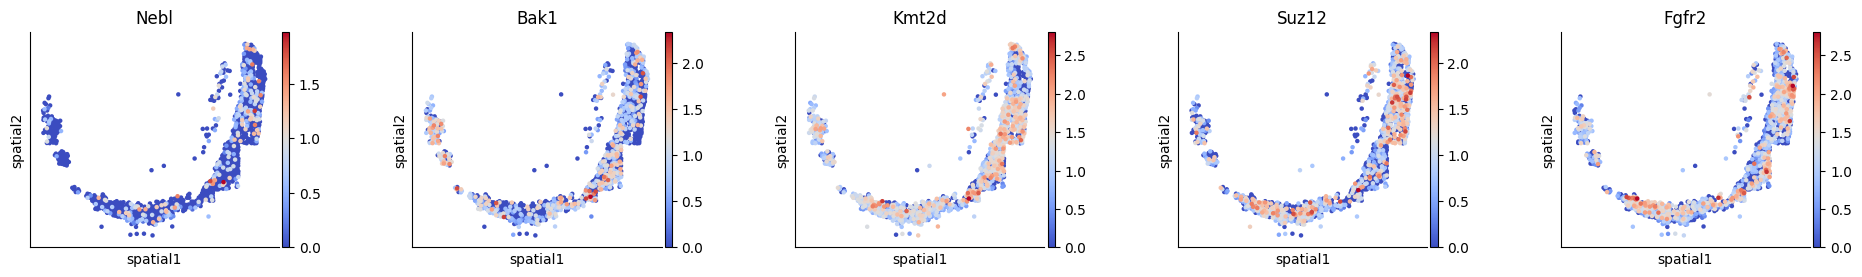

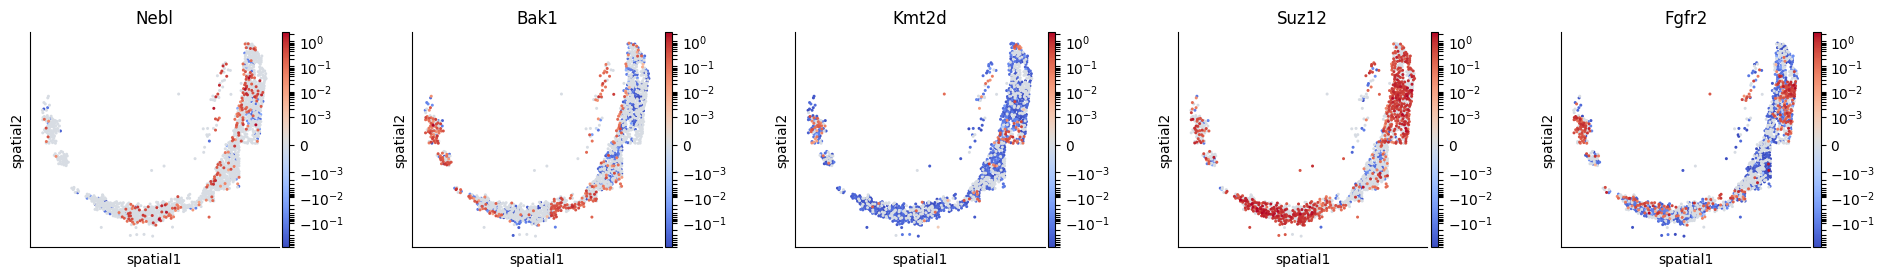

In [35]:
figsize(3.8,2.8)
rcParams['axes.spines.left'] = True
rcParams['axes.spines.bottom'] = True
sc.pl.spatial(spinaladata,spot_size=3,color=['Nebl','Bak1','Kmt2d','Suz12','Fgfr2'],ncols=6,cmap='coolwarm',basis='spatial',save='nonspatialsdg.pdf')
sc.pl.spatial(saliadata,spot_size=2,color=['Nebl','Bak1','Kmt2d','Suz12','Fgfr2'],ncols=6,cmap='coolwarm',basis='spatial',norm = colors.SymLogNorm(linthresh=0.001,base=10),save='nonspatialsdg-saliency.pdf')

## Forebrain/Midbrain/Hindbrain

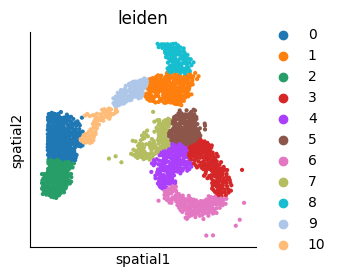

In [36]:
spinaladata = adata[scmetadata['celltype_mapped_refined']=='Forebrain/Midbrain/Hindbrain',:].copy()
spinaladata = spinaladata[spinaladata.obs['y_global']<1430].copy()
spinaladata = spinaladata[spinaladata.obs['x_global']<1630].copy()

sc.pp.neighbors(spinaladata,use_rep='spatial')
sc.tl.leiden(spinaladata,resolution=0.5)
sc.pl.spatial(spinaladata,color='leiden',spot_size=2,basis='spatial') 

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'name' as categorical


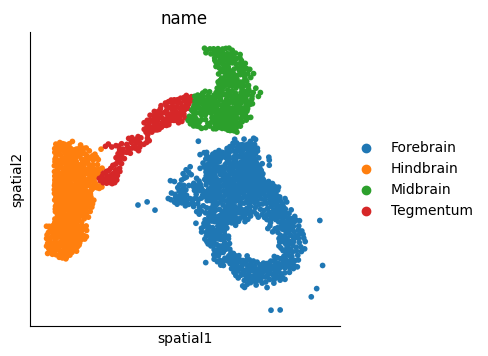

In [37]:

spinaladata.obs['name'] = spinaladata.obs['leiden'].copy().astype(str)
spinaladata.obs.loc[spinaladata.obs['leiden']=='0','name'] ='Hindbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='1','name'] ='Midbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='2','name'] ='Hindbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='3','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='4','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='5','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='6','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='7','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='8','name'] ='Midbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='9','name'] ='Tegmentum'
spinaladata.obs.loc[spinaladata.obs['leiden']=='10','name'] ='Tegmentum'
figsize(4,4)
sc.pl.spatial(spinaladata,color='name',spot_size=2,basis='spatial',save='embro_brainsep') 

In [150]:
cbm

<module 'colorbm' from '/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/colorbm/__init__.py'>

In [38]:
# spinaladata = spinaladata[spinaladata.obs.name.isin(['Midbrain','Tegmentum']),:]
spinalcoorddata = np.array(spinaladata.X)
spinalmetadata = spinaladata.obs

In [39]:
from tqdm import tqdm
capt = Captummodel(testmodel.netE,stembedding.detach())
capt.eval()
spinalcoorddata = torch.Tensor(spinalcoorddata).cuda()

allsali = []
allbestidx = []
alldelta = []
allemb=[]
for i in tqdm(range(spinalcoorddata.shape[0])):
    inputdata = spinalcoorddata[i].unsqueeze(0)
    scembedding = testmodel.netE(inputdata)
    allemb.append(scembedding.detach().cpu().numpy())
    spinal2st = scembedding.mm(stembedding.detach().t())
    idx = spinal2st.argmax()
    ig = IntegratedGradients(capt)
    attributions,delta = ig.attribute(inputdata,target=idx,return_convergence_delta=True)
    # attributions, delta = nt.attribute(inputdata,baselines= torch.rand_like(inputdata)*0.01,nt_type='smoothgrad', stdevs=0.02, nt_samples=5, target=idx, return_convergence_delta=True)
    allsali.append(attributions.detach().cpu().numpy()[0])
    alldelta.append(delta.mean().item())

allsali = np.array(allsali)

100%|██████████| 1703/1703 [00:11<00:00, 142.74it/s]


In [40]:
saliadata = sc.AnnData(pd.DataFrame(allsali,columns=scdata.columns,index = spinaladata.obs_names),obs = spinaladata.obs)
saliadata.obsm['spatial'] = spinaladata.obsm['spatial']
saliadata.obsm['spatialDA'] = spinaladata.obsm['spatialDA']

In [41]:
allscemb =np.squeeze(np.array(allemb))
embadata = sc.AnnData(pd.DataFrame(allscemb,index = spinaladata.obs_names),obs = spinaladata.obs)
embadata.obsm['spatial'] = spinaladata.obsm['spatial']
embadata.obsm['spatialDA'] = spinaladata.obsm['spatialDA']
sc.pp.neighbors(embadata,use_rep='X',metric='cosine')
sc.tl.umap(embadata)

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


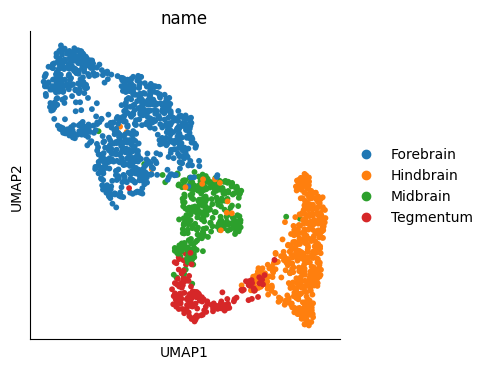

In [42]:
sc.pl.umap(embadata,color=['name'],save='embro_brainsep_emb')

In [43]:
clsspinaladata = spinaladata.copy()
sc.pp.scale(clsspinaladata)
sc.pp.pca(clsspinaladata)
sc.pp.neighbors(clsspinaladata)
sc.tl.umap(clsspinaladata)

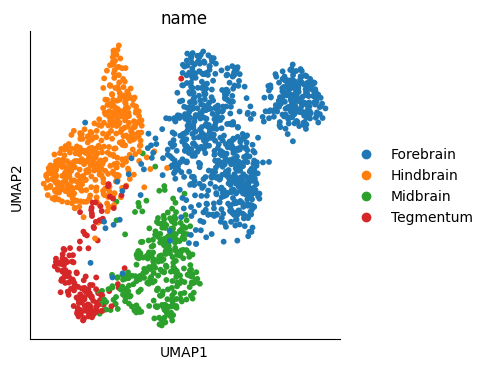

In [44]:
sc.pl.umap(clsspinaladata,color=['name'],save='embro_brainsep_raw')

# Search Sigma

In [45]:
sc_gtcoord = scmetadata[['x_global','y_global']]
true_sc2sc = scipy.spatial.distance.cdist(sc_gtcoord,sc_gtcoord)
true_argmask = np.argsort(true_sc2sc,axis=1)

In [46]:
class setting( object ):
    pass
seed_all(2022)
krgc={}
allloss = {}
for sig in np.arange(0,10,1).tolist():
    opt= setting()
    setattr(opt, 'device', 'cuda:0')
    setattr(opt, 'outf', 'log/Mouse_E1z2—sigma-search')
    setattr(opt, 'n_genes', 351)
    setattr(opt, 'no_bn', False)
    setattr(opt, 'lr', 0.002)
    setattr(opt, 'sigma', sig)
    setattr(opt, 'alpha', 0.8)
    setattr(opt, 'verbose', False)
    setattr(opt, 'mmdbatch', 1000)
    setattr(opt, 'dp', dp)

    testmodel = SOmodel(opt)
    testmodel.togpu()
    loss_curve = testmodel.train_wholedata(400,torch.tensor(scdata.values).float(),torch.tensor(stdata.values).float(),torch.tensor(spcoor.values).float())
    testmodel.modeleval()
    scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
    scembedding = scembedding.detach().cpu().numpy()
    sc2sc = np.matmul(scembedding,scembedding.T)
    argmask = np.argsort(-sc2sc,axis=1)
    krg = []
    for k in range(1,26):
        k_list = []
        for i in range(argmask.shape[0]):
            k_list.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
        krg.append(np.mean(k_list))
    allloss['sig_'+str(sig)] = loss_curve
    krgc['sig_'+str(sig)] = krg

In [47]:
pd.DataFrame(krgc).to_csv('./result/sigma_MouseE1z2.csv')

In [48]:
import pickle
with open('./result/sigma_MouseE1z2_loss.pkl','wb') as f:
    pickle.dump(loss_curve,f)

Text(0, 0.5, 'hit number')

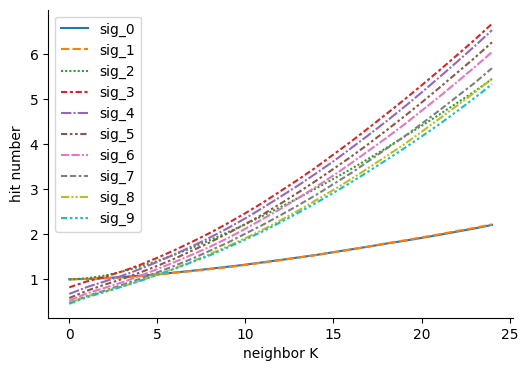

In [49]:
import seaborn as sns
figsize(6,4)
ax = sns.lineplot(data = pd.DataFrame(krgc))
plt.xlabel('neighbor K')
plt.ylabel('hit number')

In [50]:
pd.DataFrame(krgc)

,sig_0,sig_1,sig_2,sig_3,sig_4,sig_5,sig_6,sig_7,sig_8,sig_9
0,1.000000,1.000000,0.996650,0.821084,0.674877,0.583350,0.528670,0.477438,0.473892,0.457340
1,1.007586,1.006207,1.021675,0.953300,0.827389,0.746798,0.687685,0.626700,0.617143,0.600788
2,1.025616,1.018227,1.081182,1.054384,0.949754,0.878818,0.808670,0.747389,0.727980,0.717241
3,1.050049,1.040197,1.170443,1.174877,1.077833,1.005025,0.931724,0.875862,0.840690,0.837340
4,1.078522,1.068768,1.279803,1.316650,1.225123,1.147586,1.074581,1.008177,0.962463,0.963645
5,1.109360,1.103054,1.405222,1.477241,1.385320,1.297734,1.227389,1.153596,1.098621,1.097044
6,1.150148,1.143744,1.549557,1.651034,1.558227,1.461872,1.385222,1.302660,1.244631,1.236847
7,1.190443,1.183251,1.703744,1.836552,1.736946,1.639704,1.551232,1.461281,1.396847,1.385123
8,1.233793,1.224926,1.872020,2.032414,1.928867,1.822857,1.725616,1.637044,1.563251,1.535665
9,1.277931,1.268276,2.043744,2.244138,2.133990,2.019310,1.912512,1.813695,1.733793,1.707291
